In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import numpy as np
from google.colab import files
import os
import cv2
import matplotlib.pyplot as plt
import random
import copy

Using TensorFlow backend.


# Getting the data

upload the dataset and unzip

In [2]:
!wget http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
!unzip -qq animeface-character-dataset.zip

--2018-12-03 20:27:26--  http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
Resolving www.nurs.or.jp (www.nurs.or.jp)... 54.187.126.238
Connecting to www.nurs.or.jp (www.nurs.or.jp)|54.187.126.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592335393 (565M) [application/zip]
Saving to: ‘animeface-character-dataset.zip’

animeface-character 100%[===================>] 564.89M  19.7MB/s    in 28s     

2018-12-03 20:27:55 (20.1 MB/s) - ‘animeface-character-dataset.zip’ saved [592335393/592335393]



split into test, validation and train data - getting data

In [0]:
x_train = []
x_val = []
x_test = []

directories = os.listdir('animeface-character-dataset/thumb/')
for directory in directories:
  dir_path = 'animeface-character-dataset/thumb/'+directory
  num_fil = 0
  num_train = 0
  num_val = 0
  num_test = 0
  if os.path.isdir(dir_path):
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        num_fil += 1
    num_train = int(round(num_fil*0.7))
    num_val = int(round((num_fil-num_train)*0.5))
    num_test = int(round(num_fil-num_train-num_val))
    i = 0
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        filepath = dir_path+"/"+filename
        if i<num_train:
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_train.append(img)
        elif i<(num_train+num_val):
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_val.append(img)
        elif i<(num_train+num_val+num_train):
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_test.append(img)
        i += 1
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

example of data

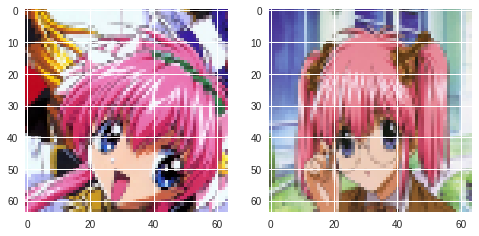

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(x_train[0])
plt.subplot(1, 2, 2)
plt.imshow(x_val[10])
plt.show()

data normalization and reshaping

In [0]:
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_val = x_val.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

In [0]:
x_train = np.reshape(x_train, (len(x_train), 64, 64, 3))
x_val = np.reshape(x_val, (len(x_val), 64, 64, 3))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 3))

# Denoising

apply noise

In [0]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

example of noisy images

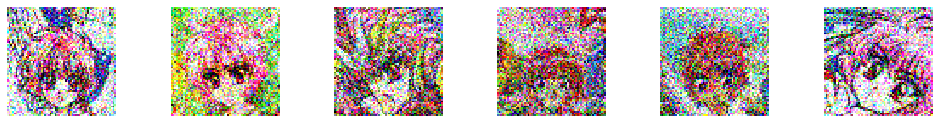

In [40]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

convolutional autoencoder model

In [0]:
input_img = Input(shape=(64, 64, 3))  # shape of the images that wil be on input

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

training of images

In [70]:
log = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_noisy, x_val))

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
10133/10133 [==============================] - 9s 890us/step - loss: 0.6436 - val_loss: 0.5930
Epoch 2/100
10133/10133 [==============================] - 8s 794us/step - loss: 0.6029 - val_loss: 0.5755
Epoch 3/100
10133/10133 [==============================] - 8s 792us/step - loss: 0.5699 - val_loss: 0.5760
Epoch 4/100
10133/10133 [==============================] - 8s 791us/step - loss: 0.5467 - val_loss: 0.5556
Epoch 5/100
10133/10133 [==============================] - 8s 794us/step - loss: 0.5392 - val_loss: 0.5385
Epoch 6/100
10133/10133 [==============================] - 8s 793us/step - loss: 0.5334 - val_loss: 0.5287
Epoch 7/100
10133/10133 [==============================] - 8s 793us/step - loss: 0.5295 - val_loss: 0.5207
Epoch 8/100
10133/10133 [==============================] - 8s 793us/step - loss: 0.5264 - val_loss: 0.5168
Epoch 9/100
10133/10133 [==============================] - 8s 793us/step - loss: 0.5240 - val_l

graph of losses

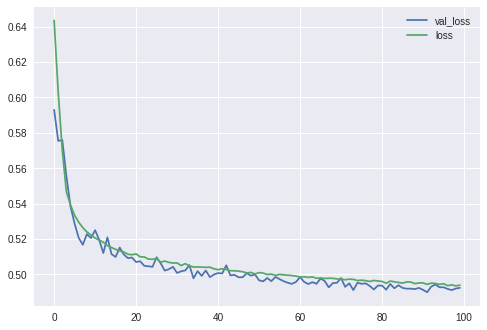

In [71]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

feeding test data into the decoder

In [0]:
decoded_imgs = autoencoder.predict(x_test_noisy)

visualizing the noisy test images, reconstructed images and original images

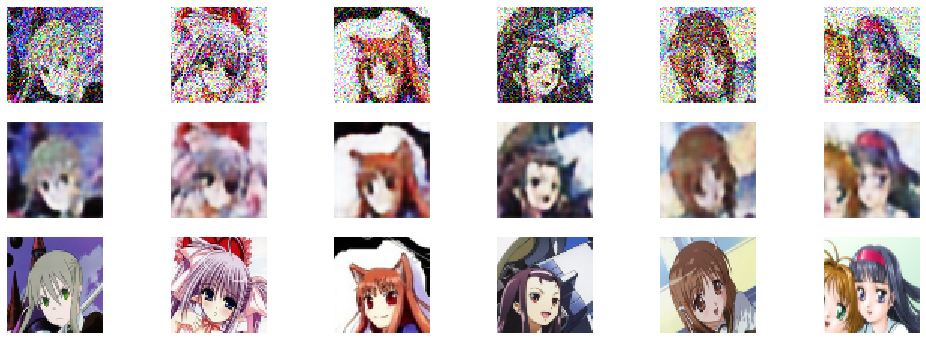

In [76]:
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display noisy
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Inpainting - stripes

creating images with stripes

In [0]:
stripes_no = 24
x_train_inpaint = copy.deepcopy(x_train)
x_val_inpaint = copy.deepcopy(x_val)
x_test_inpaint = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_train_inpaint[i])):
        if j in stripes:
            x_train_inpaint[i][j] = np.zeros((64,1))
            
for i in range(len(x_val_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_val_inpaint[i])):
        if j in stripes:
            x_val_inpaint[i][j] = np.zeros((64,1))

for i in range(len(x_test_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_test_inpaint[i])):
        if j in stripes:
            x_test_inpaint[i][j] = np.zeros((64,1))

example of images with stripes

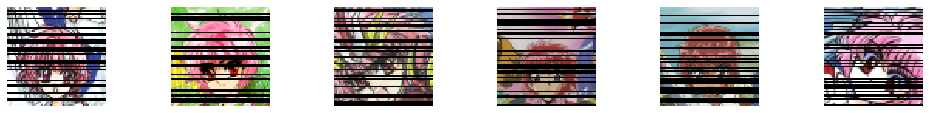

In [79]:
n = 7
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

training on the same network model

In [81]:
log = autoencoder.fit(x_train_inpaint, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_inpaint, x_val))

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
10133/10133 [==============================] - 9s 844us/step - loss: 0.6394 - val_loss: 0.6663
Epoch 2/100
10133/10133 [==============================] - 8s 744us/step - loss: 0.6227 - val_loss: 0.6560
Epoch 3/100
10133/10133 [==============================] - 8s 744us/step - loss: 0.5737 - val_loss: 0.5404
Epoch 4/100
10133/10133 [==============================] - 8s 747us/step - loss: 0.5466 - val_loss: 0.5324
Epoch 5/100
10133/10133 [==============================] - 8s 747us/step - loss: 0.5397 - val_loss: 0.5352
Epoch 6/100
10133/10133 [==============================] - 8s 748us/step - loss: 0.5354 - val_loss: 0.5316
Epoch 7/100
10133/10133 [==============================] - 8s 746us/step - loss: 0.5339 - val_loss: 0.5265
Epoch 8/100
10133/10133 [==============================] - 8s 746us/step - loss: 0.5308 - val_loss: 0.5239
Epoch 9/100
10133/10133 [==============================] - 8s 746us/step - loss: 0.5285 - val_l

graph of losses

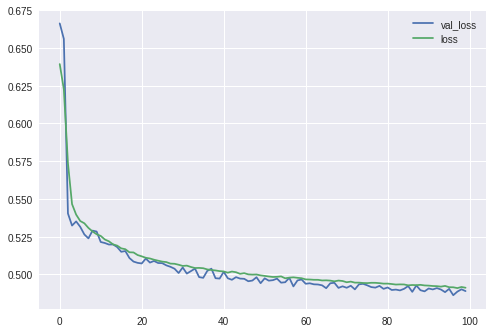

In [82]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

feeding test data into the decoder

In [0]:
decoded_imgs_inpaint = autoencoder.predict(x_test_inpaint)

visualization of the input test images with stripes, reconstructed images and original images

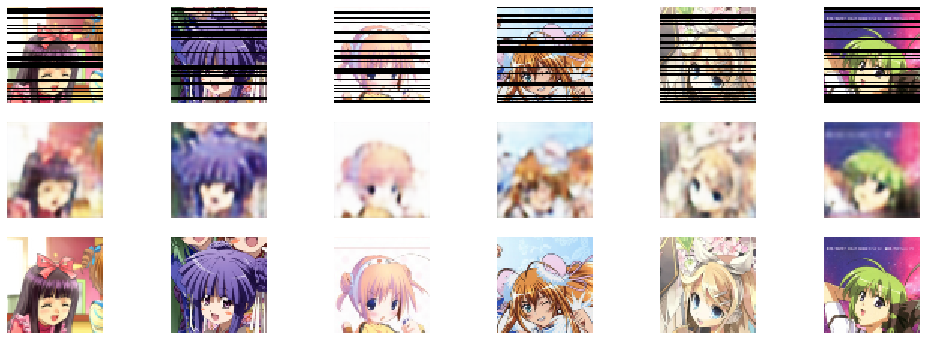

In [85]:
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display noisy
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_inpaint[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs_inpaint[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Inpainting - blocks

creating images with randomly placed gray blocks

In [0]:
block_size = 24
x_train_inpaint_block = copy.deepcopy(x_train)
x_val_inpaint_block = copy.deepcopy(x_val)
x_test_inpaint_block = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_train_inpaint_block[i][x+j][y+k] = 0.5 # gray color
            
for i in range(len(x_val_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_val_inpaint_block[i][x+j][y+k] = 0.5 

for i in range(len(x_test_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_test_inpaint_block[i][x+j][y+k] = 0.5

example of images with randomly placed gray blocks

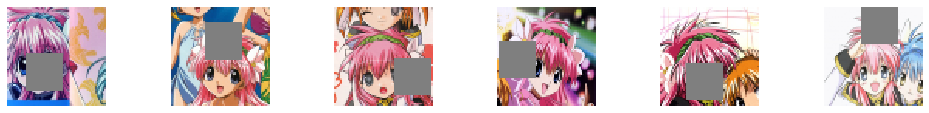

In [10]:
n = 7
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint_block[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

fitting data into the autoencoder

In [11]:
log = autoencoder.fit(x_train_inpaint_block, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_inpaint_block, x_val),
               verbose=2)

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
 - 13s - loss: 0.6428 - val_loss: 0.6404
Epoch 2/100
 - 7s - loss: 0.6291 - val_loss: 0.6389
Epoch 3/100
 - 7s - loss: 0.5793 - val_loss: 0.5826
Epoch 4/100
 - 7s - loss: 0.5576 - val_loss: 0.5474
Epoch 5/100
 - 7s - loss: 0.5495 - val_loss: 0.5401
Epoch 6/100
 - 7s - loss: 0.5445 - val_loss: 0.5387
Epoch 7/100
 - 7s - loss: 0.5403 - val_loss: 0.5364
Epoch 8/100
 - 7s - loss: 0.5376 - val_loss: 0.5405
Epoch 9/100
 - 7s - loss: 0.5358 - val_loss: 0.5292
Epoch 10/100
 - 7s - loss: 0.5339 - val_loss: 0.5337
Epoch 11/100
 - 7s - loss: 0.5319 - val_loss: 0.5360
Epoch 12/100
 - 7s - loss: 0.5300 - val_loss: 0.5290
Epoch 13/100
 - 7s - loss: 0.5298 - val_loss: 0.5220
Epoch 14/100
 - 7s - loss: 0.5281 - val_loss: 0.5307
Epoch 15/100
 - 7s - loss: 0.5274 - val_loss: 0.5210
Epoch 16/100
 - 7s - loss: 0.5250 - val_loss: 0.5276
Epoch 17/100
 - 7s - loss: 0.5241 - val_loss: 0.5275
Epoch 18/100
 - 7s - loss: 0.5230 - val_loss: 0.5174
Epoch

graph of losses

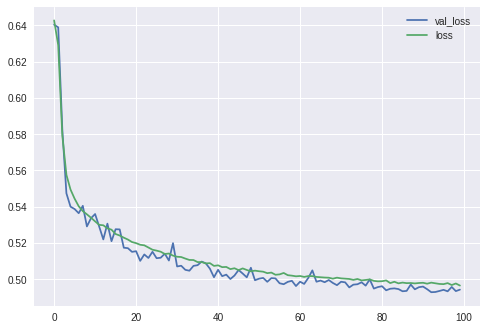

In [12]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

predicting the test data with blocks

In [0]:
decoded_imgs_inpaint_block = autoencoder.predict(x_test_inpaint_block)

visualization of the input test images with gray blocks, reconstructed images and original images

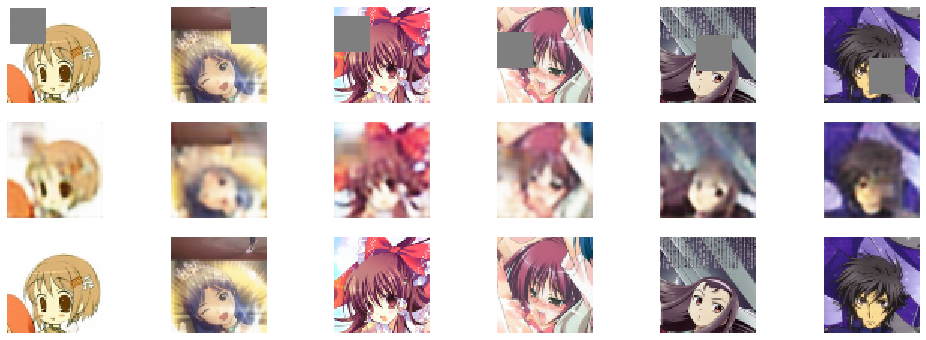

In [18]:
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display noisy
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_inpaint_block[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_imgs_inpaint_block[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()